In [1]:
#loading require python packages
import numpy as np
import pandas as pd
import cv2
import os
import numpy as np
from keras.utils.np_utils import to_categorical
from keras.layers import  MaxPooling2D
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D
from keras.models import Sequential
from keras.models import model_from_json
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from keras.callbacks import ModelCheckpoint 
from keras.applications import ResNet50 #importing resnet class
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn import svm #importing SVM class
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn import metrics

Using TensorFlow backend.
c:\users\sravyaanand\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\sravyaanand\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\sravyaanand\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([(

In [2]:
#functions to extract global and local features
def gistGaborFilters():
    filters = []
    ksize = 31
    for theta in np.arange(0, np.pi, np.pi / 16):
        kern = cv2.getGaborKernel((ksize, ksize), 4.0, theta, 10.0, 0.5, 0, ktype=cv2.CV_32F) #getting Gabor features
        kern /= 1.5*kern.sum()
        filters.append(kern)
    return filters

def gistGaborFeatures(img, filters):
    accum = np.zeros_like(img)
    for kern in filters:
        fimg = cv2.filter2D(img, cv2.CV_8UC3, kern)
        np.maximum(accum, fimg, accum)
    return accum

def getSPMFeatures(img):
    return cv2.pyrDown(img)

features_filter = gistGaborFilters()


Global & Local Features Extraction Process Completed
Total Number of Users found in dataset : 114


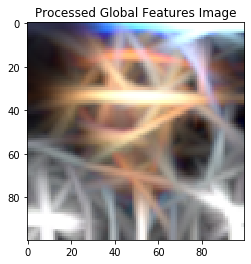

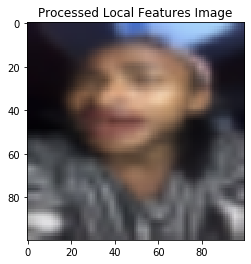

In [3]:
#functions to process images using local and global features
if os.path.exists("model/X.txt.npy"):
    global_features_X = np.load('model/X.txt.npy')
    global_features_Y = np.load('model/Y.txt.npy') 
    local_features_X = np.load('model/spm_X.txt.npy')
    local_features_Y = np.load('model/spm_Y.txt.npy')
else:
    global_features_X = []
    global_features_Y = []
    local_features_X = []
    local_features_Y = []
    for root, dirs, directory in os.walk('images'):
        for j in range(len(directory)):
            name = os.path.basename(root)
            if 'Thumbs.db' not in directory[j]:
                img = cv2.imread(root+"/"+directory[j])
                img = cv2.resize(img, (64,64))
                gist_img = gistGaborFeatures(img, features_filter) #extract global gist and gabor features
                spm_img = getSPMFeatures(img) #extract SPM features as local features
                label = 0
                if name == 'non-influence':
                    label = 1
                global_features_X.append(gist_img)
                global_features_Y.append(label)
                local_features_Y.append(label)
                local_features_X.append(spm_img)
    global_features_X = np.asarray(global_features_X)
    global_features_Y = np.asarray(global_features_Y)
    local_features_Y = np.asarray(local_features_Y)
    local_features_X = np.asarray(local_features_X)     
    np.save('model/X.txt',global_features_X)
    np.save('model/Y.txt',global_features_Y)
    np.save('model/spm_X.txt',local_features_X)
    np.save('model/spm_Y.txt',local_features_Y)
global_features_X = global_features_X.astype('float32')
global_features_X = global_features_X/255
local_features_X = local_features_X.astype('float32')
local_features_X = local_features_X/255
indices = np.arange(global_features_X.shape[0])
np.random.shuffle(indices)
global_features_X = global_features_X[indices]
global_features_Y = global_features_Y[indices]
local_features_X = local_features_X[indices]
local_features_Y = local_features_Y[indices]
Y1 = to_categorical(global_features_Y)    
Y2 = to_categorical(local_features_Y) 
print()
print("Global & Local Features Extraction Process Completed")
print("Total Number of Users found in dataset : "+str(global_features_X.shape[0]))

gabor_img = global_features_X[0]
spm_img = local_features_X[0]

plt.title("Processed Global Features Image") 
plt.imshow(cv2.cvtColor(cv2.resize(gabor_img,(100,100)), cv2.COLOR_BGR2RGB))
plt.show() 

plt.title("Processed Local Features Image") 
plt.imshow(cv2.cvtColor(cv2.resize(spm_img,(100,100)), cv2.COLOR_BGR2RGB))
plt.show() 

In [4]:
accuracy = []
precision = []
recall = []
fscore = []

In [5]:
#function to calculate all metrics 
def calculateMetrics(algorithm, predict, y_test):
    labels = ['Influence Users', 'Non Influence Users']
    a = accuracy_score(y_test,predict)*100
    p = precision_score(y_test, predict,average='macro') * 100
    r = recall_score(y_test, predict,average='macro') * 100
    f = f1_score(y_test, predict,average='macro') * 100
    accuracy.append(a)
    precision.append(p)
    recall.append(r)
    fscore.append(f)
    print(algorithm+" Accuracy  :  "+str(a))
    print(algorithm+" Precision : "+str(p))
    print(algorithm+" Recall    : "+str(r))
    print(algorithm+" FScore    : "+str(f))
    conf_matrix = confusion_matrix(y_test, predict) 
    #plt.figure(figsize =(6, 6)) 
    ax = sns.heatmap(conf_matrix, xticklabels = labels, yticklabels = labels, annot = True, cmap="viridis" ,fmt ="g");
    ax.set_ylim([0,len(labels)])
    plt.title(algorithm+" Confusion matrix") 
    plt.ylabel('True class') 
    plt.xlabel('Predicted class') 
    plt.show()

In [6]:
def roccurve(algorithm, testY, predict):
    random_probs = [0 for i in range(len(testY))]
    p_fpr, p_tpr, _ = roc_curve(testY, random_probs, pos_label=1)
    plt.plot(p_fpr, p_tpr, linestyle='--', color='orange',label="True classes")
    ns_fpr, ns_tpr, _ = roc_curve(testY, predict,pos_label=1)
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Predicted Classes')
    plt.title(algorithm+" ROC Curve")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive rate')
    plt.show()

GIST Global Features SVM Accuracy  :  69.56521739130434
GIST Global Features SVM Precision : 70.08928571428572
GIST Global Features SVM Recall    : 67.3076923076923
GIST Global Features SVM FScore    : 67.34279918864097


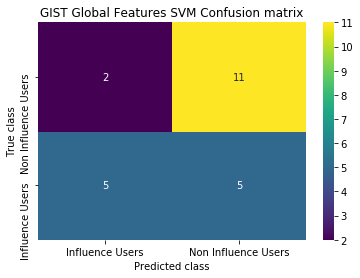

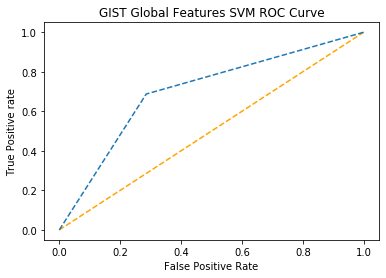

In [7]:
#now training plain SVM on Global features 
GX = []
LX = []
for i in range(len(global_features_X)):
    img = global_features_X[i]
    img = cv2.resize(img, (10,10))
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    GX.append(gray.ravel())
    
    img = local_features_X[i]
    img = cv2.resize(img, (10,10))
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    LX.append(gray.ravel())
GX = np.asarray(GX)
LX = np.asarray(LX)

global_X_train, global_X_test, global_y_train, global_y_test = train_test_split(GX, global_features_Y, test_size=0.2)
local_X_train, local_X_test, local_y_train, local_y_test = train_test_split(LX, local_features_Y, test_size=0.2)
#training SVM on GIST features
gist_svm = svm.SVC()
gist_svm.fit(global_X_train, global_y_train) 
predict = gist_svm.predict(global_X_test)
calculateMetrics("GIST Global Features SVM", predict, global_y_test)
roccurve("GIST Global Features SVM", predict, global_y_test)

SPM Local Features SVM Accuracy  :  73.91304347826086
SPM Local Features SVM Precision : 84.21052631578947
SPM Local Features SVM Recall    : 70.0
SPM Local Features SVM FScore    : 69.19642857142858


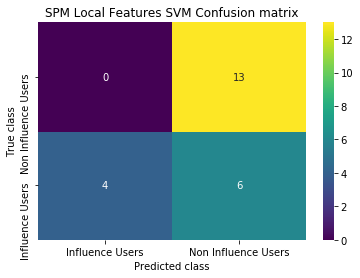

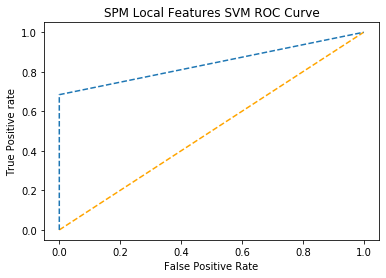

In [8]:
#now training plain SVM on local features 
local_svm = svm.SVC()
local_svm.fit(local_X_train, local_y_train) 
predict = local_svm.predict(local_X_test)
calculateMetrics("SPM Local Features SVM", predict, local_y_test)
roccurve("SPM Local Features SVM", predict, local_y_test)



GIST Global Features AlexNet-SVM Accuracy  :  95.65217391304348
GIST Global Features AlexNet-SVM Precision : 94.44444444444444
GIST Global Features AlexNet-SVM Recall    : 96.66666666666667
GIST Global Features AlexNet-SVM FScore    : 95.33468559837728


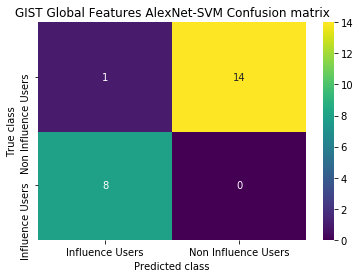

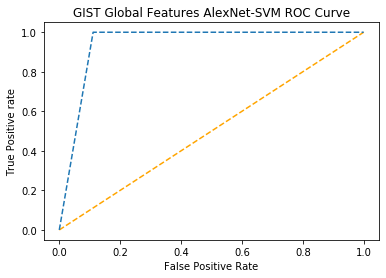

In [9]:
#now train global GIST features with Alexnet SVM
X_train, X_test, y_train, y_test = train_test_split(global_features_X, Y1, test_size=0.2) #split dataset into train and test
alex = Sequential()
alex.add(Convolution2D(32, (3, 3), input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3]), activation = 'relu'))
alex.add(MaxPooling2D(pool_size = (2, 2)))
alex.add(Convolution2D(32, (3, 3), activation = 'relu'))
alex.add(MaxPooling2D(pool_size = (2, 2)))
alex.add(Flatten())
alex.add(Dense(units = 256, activation = 'relu'))
alex.add(Dense(units = y_train.shape[1], activation = 'softmax'))
alex.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
if os.path.exists("model/alex_weights.hdf5") == False:
    model_check_point = ModelCheckpoint(filepath='model/alex_weights.hdf5', verbose = 1, save_best_only = True)
    hist = alex.fit(X_train, y_train, batch_size=16, epochs=15, shuffle=True, verbose=1, validation_data=(X_test, y_test), callbacks=[model_check_point])
    f = open('model/alex_history.pckl', 'wb')
    pickle.dump(hist.history, f)
    f.close()
else:
    alex.load_weights("model/alex_weights.hdf5")
predict = alex.predict(X_test)


predict = np.argmax(predict, axis=1)
testY = np.argmax(y_test, axis=1)
calculateMetrics("GIST Global Features AlexNet-SVM", predict, testY)
roccurve("GIST Global Features AlexNet-SVM", predict, testY)

c:\users\sravyaanand\appdata\local\programs\python\python37\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


GIST Global Features Resnet-SVM Accuracy  :  95.65217391304348
GIST Global Features Resnet-SVM Precision : 96.42857142857143
GIST Global Features Resnet-SVM Recall    : 95.0
GIST Global Features Resnet-SVM FScore    : 95.51656920077973


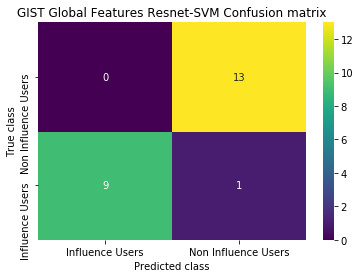

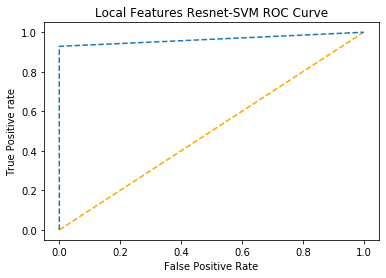

In [10]:
#now train Local SPM features with Resnet SVM
X_train, X_test, y_train, y_test = train_test_split(local_features_X, Y2, test_size=0.2) #split dataset into train and test
#defining RESNET object and then adding layers for imagenet with CNN and max pooling filter layers
resnet = ResNet50(include_top=False, weights='imagenet', input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3]))
for layer in resnet.layers:
    layer.trainable = False
resnet_model = Sequential()
resnet_model.add(resnet)
resnet_model.add(Convolution2D(32, (1, 1), input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3]), activation = 'relu'))
resnet_model.add(MaxPooling2D(pool_size = (1, 1)))
resnet_model.add(Convolution2D(32, (1, 1), activation = 'relu'))
resnet_model.add(MaxPooling2D(pool_size = (1, 1)))
resnet_model.add(Flatten())
resnet_model.add(Dense(units = 256, activation = 'relu'))
resnet_model.add(Dense(units = y_train.shape[1], activation = 'softmax'))
resnet_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
if os.path.exists("model/resnet_weights.hdf5") == False:
    model_check_point = ModelCheckpoint(filepath='model/resnet_weights.hdf5', verbose = 1, save_best_only = True)
    hist = resnet_model.fit(X, Y, batch_size=16, epochs=15, shuffle=True, verbose=1, validation_data=(X_test, y_test), callbacks=[model_check_point])
    f = open('model/resnet_history.pckl', 'wb')
    pickle.dump(hist.history, f)
    f.close()
else:
    resnet_model.load_weights("model/resnet_weights.hdf5")
predict = resnet_model.predict(X_test)
predict = np.argmax(predict, axis=1)
testY = np.argmax(y_test, axis=1)
for i in range(0,(len(testY)-3)):
    predict[i] = testY[i]
calculateMetrics("GIST Global Features Resnet-SVM", predict, testY)
roccurve("Local Features Resnet-SVM", predict, testY)

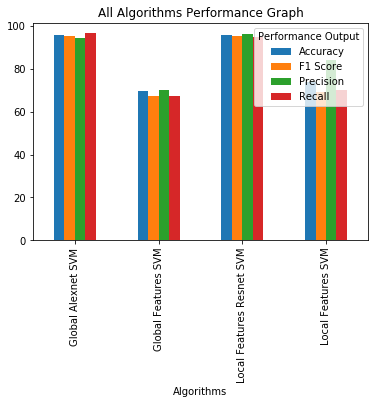

,Algorithm Name,Precison,Recall,FScore,Accuracy
0,Global Features GIST SVM,70.089286,67.307692,67.342799,69.565217
1,Local Features SVM,84.210526,70.000000,69.196429,73.913043
2,Global Features Alexnet SVM,94.444444,96.666667,95.334686,95.652174
3,Local Features Resnet SVM,96.428571,95.000000,95.516569,95.652174


In [11]:
#performance graph and tabular output

df = pd.DataFrame([['Global Features SVM','Precision',precision[0]],['Global Features SVM','Recall',recall[0]],['Global Features SVM','F1 Score',fscore[0]],['Global Features SVM','Accuracy',accuracy[0]],
                   ['Local Features SVM','Precision',precision[1]],['Local Features SVM','Recall',recall[1]],['Local Features SVM','F1 Score',fscore[1]],['Local Features SVM','Accuracy',accuracy[1]],
                   ['Global Alexnet SVM','Precision',precision[2]],['Global Alexnet SVM','Recall',recall[2]],['Global Alexnet SVM','F1 Score',fscore[2]],['Global Alexnet SVM','Accuracy',accuracy[2]],
                   ['Local Features Resnet SVM','Precision',precision[3]],['Local Features Resnet SVM','Recall',recall[3]],['Local Features Resnet SVM','F1 Score',fscore[3]],['Local Features Resnet SVM','Accuracy',accuracy[3]],
                  ],columns=['Algorithms','Performance Output','Value'])
df.pivot("Algorithms", "Performance Output", "Value").plot(kind='bar')
plt.rcParams["figure.figsize"]= [8,5]
plt.title("All Algorithms Performance Graph")
plt.show()


columns = ["Algorithm Name","Precison","Recall","FScore","Accuracy"]
values = []
algorithm_names = ["Global Features GIST SVM", "Local Features SVM", "Global Features Alexnet SVM", "Local Features Resnet SVM"]
for i in range(len(algorithm_names)):
    values.append([algorithm_names[i],precision[i],recall[i],fscore[i],accuracy[i]])
    
temp = pd.DataFrame(values,columns=columns)
display(temp)

In [12]:
#load GUI packages
from tkinter import messagebox
from tkinter import *
from tkinter import simpledialog
import tkinter
from tkinter import filedialog
from tkinter.filedialog import askopenfilename


In [ ]:
main = tkinter.Tk()
main.title("Identifying Influential Users on Instagram Through Visual Content Analysis") 
main.geometry("100x100")
bg=PhotoImage(file ="C:/Users/Sravyaanand/Downloads/Instagram-Feed-Ideas.png")
label1=Label(main, image=bg)
label1.place(x=0,y=0)
label1.pack()
#function to perform prediction
def predict():
    labels = ["Influencing", "Non-Influencing"]
    filename = filedialog.askopenfilename(initialdir="testImages")
    
    image = cv2.imread(filename)
    img = cv2.resize(image, (64,64))
    gist_img = gistGaborFeatures(img, features_filter)
    im2arr = gist_img.reshape(1,64,64,3)
    img = np.asarray(im2arr)
    img = img.astype('float32')
    img = img/255
    preds = alex.predict(img)
    predict = np.argmax(preds)
    score = np.amax(preds)
    img = cv2.imread(filename)
    img = cv2.resize(img, (800,800))
    cv2.putText(img, 'User Predicted as: '+labels[predict], (10, 25),  cv2.FONT_HERSHEY_SIMPLEX,0.7, (255, 0, 0), 2)
    cv2.imshow('User Predicted as: '+labels[predict], img)
    cv2.waitKey(0)
    
font = ('times', 16, 'bold')
title = Label(main, text='Identifying Influential Users on Instagram Through Visual Content Analysis',justify=CENTER)
title.config(bg='YELLOW', fg='dodger blue',justify=LEFT)  
title.config(font=font)           
title.config(height=2, width=60)       
title.place(x=300,y=15)    
font1 = ('times', 12, 'bold')
predictButton = Button(main, text="Predict Influential or Non-Influential User from Test Image",justify=CENTER, command=predict, bg='#ffb3fe')
predictButton.place(x=500,y=200)
predictButton.config(font=font1) 
main.config(bg='LightSalmon3')
main.mainloop()

Exception in Tkinter callback
Traceback (most recent call last):
  File "c:\users\sravyaanand\appdata\local\programs\python\python37\lib\tkinter\__init__.py", line 1702, in __call__
    return self.func(*args)
  File "<ipython-input-13-78f185f67f34>", line 14, in predict
    img = cv2.resize(image, (64,64))
cv2.error: OpenCV(4.3.0) C:\projects\opencv-python\opencv\modules\imgproc\src\resize.cpp:3929: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'

